In [1]:
import torch
import numpy as np
import cv2
from dcnet import DCNet
from dataset_utility import ToTensor
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import torch.nn.functional as F
import matplotlib.cm as cm
import re

# Sampling the data examples

In [9]:
os_data_dict = {
    "distribute_four": [3149],
    "distribute_nine": [6448],
    "center_single": [1228],
    "in_center_single_out_center_single": [218],
    "in_distribute_four_out_center_single": [7029, 2739],
    "left_center_single_right_center_single": [128],
    "up_center_single_down_center_single": [429],
}

In [7]:
llm_data_dict = {
    "distribute_four": [5878, 1588],
    "center_single": [4088, 9138],
    "in_center_single_out_center_single": [1229, 219],
    "left_center_single_right_center_single": [6569, 7108],
}

# Find correct/wrong prediction

In [15]:
def find_predictions_by_match(model, base_dir, match_op='==', max_files=20, img_size=96):
    """
    Find files where the model prediction matches or mismatches the label based on `match_op`.

    Args:
        model: Trained DCNet model
        base_dir: Path to RAVEN directory
        match_op: '==' for correct, '!=' for incorrect
        max_files: Max number of files to return
        img_size: Resize shape (img_size, img_size)

    Returns:
        List of matching file paths
    """
    assert match_op in ['==', '!='], "match_op must be '==' or '!='"

    model.eval()
    device = next(model.parameters()).device
    matching_files = []
    pattern = re.compile(r'RAVEN_\d+_test\.npz')

    for root, _, files in os.walk(base_dir):
        for fname in files:
            if not pattern.match(fname):
                continue

            path = os.path.join(root, fname)
            data = np.load(path)
            images = data['image']
            target = int(data['target'])

            # Resize and convert to tensor
            images_resized = np.stack([
                cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
                for img in images
            ])
            tf = ToTensor()
            images_tensor = tf(images).unsqueeze(0).to(torch.device("mps"))
            
            # images_tensor = torch.tensor(images_resized, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(images_tensor)
                pred = torch.argmax(output, dim=1).item()

            # Check condition
            is_match = pred == target
            if (match_op == '==' and is_match) or (match_op == '!=' and not is_match):
                matching_files.append((path, pred, target))
                if len(matching_files) == max_files:
                    return matching_files

    return matching_files

In [ ]:
data_path = "dataset/experiment_v3_dataset/in_center_single_out_center_single"
# Find first 20 correct predictions
correct = find_predictions_by_match(model, data_path, match_op='==')

# Find first 20 incorrect predictions

In [ ]:
correct
# incorrect

# Saving dataset images

In [12]:
def process_raven_dict(data_dict, image_prefix):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    tf = ToTensor()
    
    # Load model once
    model = DCNet(dim=64).to(device)
    model.load_state_dict(torch.load('model_new_04.pth', map_location=device))
    model.eval()

    for category, questions in data_dict.items():
        for sample_id in questions:
            fname = f"RAVEN_{sample_id}_test.npz"
            path = os.path.join('dataset', 'experiment_v3_dataset', category, fname)
            out_dir = os.path.join('os_explanations', f'os_{sample_id}')

            data = np.load(path)
            images = data['image']  # shape (16, 640, 640)
            target = data['target'].item()
            
            images_tensor = tf(images).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(images_tensor)
                pred = torch.argmax(output, dim=1).item()

            print(f"{fname}:\nPred: {pred}, True: {target}")
            
            # Choose folder name prefix
            if image_prefix.lower() == 'os':
                folder_name = os.path.join('images', f"OS_{sample_id}")
            else:
                folder_name = os.path.join('images', f"LLM_{sample_id}")

            os.makedirs(os.path.join(folder_name, 'matrix'), exist_ok=True)
            os.makedirs(os.path.join(folder_name, 'choices'), exist_ok=True)
            
            for i in range(0, 8):
                img = Image.fromarray(images[i], mode='L')
                img.save(os.path.join(folder_name, 'matrix', f'img_{i+1}.png'))
            
            for i in range(8, 16):
                img = Image.fromarray(images[i], mode='L')
                img.save(os.path.join(folder_name, 'choices', f'choice_{((i)%8)+1}.png'))


In [13]:
process_raven_dict(os_data_dict, image_prefix='OS')
process_raven_dict(llm_data_dict, image_prefix='LLM')

RAVEN_3149_test.npz:
Pred: 1, True: 1
RAVEN_6448_test.npz:
Pred: 5, True: 5
RAVEN_1228_test.npz:
Pred: 1, True: 1
RAVEN_218_test.npz:
Pred: 4, True: 4
RAVEN_7029_test.npz:
Pred: 7, True: 7
RAVEN_2739_test.npz:
Pred: 3, True: 1
RAVEN_128_test.npz:
Pred: 6, True: 7
RAVEN_429_test.npz:
Pred: 7, True: 6
RAVEN_5878_test.npz:
Pred: 7, True: 7
RAVEN_1588_test.npz:
Pred: 5, True: 5
RAVEN_4088_test.npz:
Pred: 7, True: 7
RAVEN_9138_test.npz:
Pred: 2, True: 6
RAVEN_1229_test.npz:
Pred: 6, True: 6
RAVEN_219_test.npz:
Pred: 1, True: 1
RAVEN_6569_test.npz:
Pred: 1, True: 0
RAVEN_7108_test.npz:
Pred: 6, True: 5


# Showing specific image as a plot

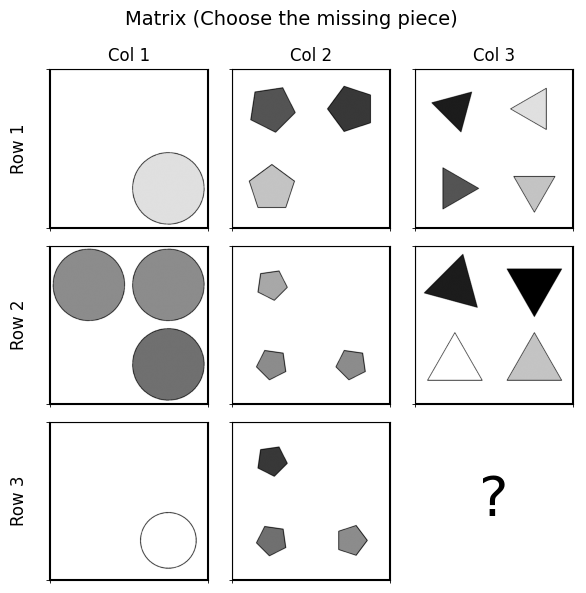

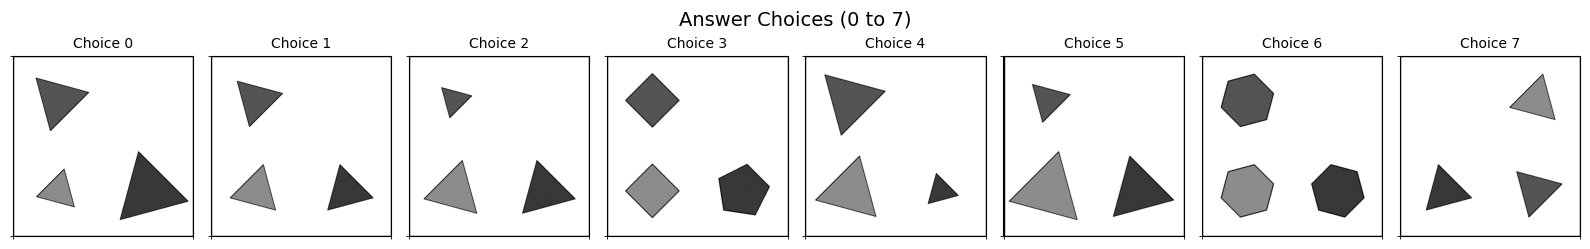

In [14]:
path = 'dataset/experiment_v3_dataset/distribute_four/RAVEN_3149_test.npz' # for example...
data = np.load(path)
images = data['image']  # (16, 160, 160)

fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(8):
    ax = axs[i // 3, i % 3]
    ax.imshow(images[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticks([0, images[i].shape[1]], minor=True)
    ax.set_yticks([0, images[i].shape[0]], minor=True)
    ax.grid(which='minor', color='black', linewidth=1.5)

# Add the "?" in the missing cell (bottom-right)
ax = axs[2, 2]
ax.axis('off')
ax.text(0.5, 0.5, '?', transform=ax.transAxes, fontsize=40, ha='center', va='center')

# Add row and column labels
for row in range(3):
    axs[row][0].set_ylabel(f"Row {row+1}", fontsize=12, labelpad=10)
for col in range(3):
    axs[0][col].set_title(f"Col {col+1}", fontsize=12)

plt.suptitle('Matrix (Choose the missing piece)', fontsize=14)
plt.tight_layout()
# plt.savefig('matrix.png', dpi=1200)
plt.show()

# ---- Display the 8 answer choices ----
fig, axs = plt.subplots(1, 8, figsize=(16, 2.5))
for i in range(8):
    axs[i].imshow(images[8 + i], cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xticks([0, images[i].shape[1]], minor=True)
    axs[i].set_yticks([0, images[i].shape[0]], minor=True)
    axs[i].grid(which='minor', color='black', linewidth=1.0)
    axs[i].set_title(f"Choice {i}", fontsize=10)

plt.suptitle('Answer Choices (0 to 7)', fontsize=14)
plt.tight_layout()
# plt.savefig('choices.png', dpi=1200)
plt.show()

# Creation of the Occlustion sensitivity heatmaps for the os_data_dict

In [3]:
def save_occlusion_heatmaps_as_images(model, images_tensor, original_images, save_dir="outputs", window_size=20, stride=10):
    """
    Saves occlusion heatmaps as individual images with heatmap overlay.
    
    Args:
        model: Trained DCNet model
        images_tensor: Tensor of shape (1, 16, H, W)
        original_images: Numpy array of shape (16, H, W)
        save_dir: Folder to save images
        window_size: Occlusion patch size
        stride: Occlusion patch stride
    """
    os.makedirs(os.path.join(save_dir, "matrix"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "choices"), exist_ok=True)

    # Get model prediction
    with torch.no_grad():
        original_output = model(images_tensor)
        pred_idx = torch.argmax(original_output, dim=1).item()
        original_score = original_output[0, pred_idx].item()

    # Get occlusion maps
    sensitivity_maps = []
    image_size = images_tensor.shape[-1]

    for img_idx in range(16):
        sensitivity_map = np.zeros((image_size, image_size))
        for i in range(0, image_size - window_size + 1, stride):
            for j in range(0, image_size - window_size + 1, stride):
                modified_input = images_tensor.clone().detach()
                modified_input[0, img_idx, i:i+window_size, j:j+window_size] = 0

                with torch.no_grad():
                    output = model(modified_input)
                    new_score = output[0, pred_idx].item()

                score_change = abs(original_score - new_score)
                sensitivity_map[i:i+window_size, j:j+window_size] += score_change

        # Normalize to [0, 1]
        map_max, map_min = sensitivity_map.max(), sensitivity_map.min()
        if map_max == map_min:
            sensitivity_map = np.ones_like(sensitivity_map) * 0.5
        else:
            sensitivity_map = (sensitivity_map - map_min) / (map_max - map_min + 1e-8)

        sensitivity_maps.append(sensitivity_map)

        # Overlay heatmap on grayscale image
        orig = original_images[img_idx]
        heatmap_color = cm.jet(sensitivity_map)[..., :3]  # shape (H, W, 3), RGB only
        grayscale_rgb = np.stack([orig] * 3, axis=-1) / 255.0

        blended = 0.5 * grayscale_rgb + 0.5 * heatmap_color
        blended = (blended * 255).astype(np.uint8)

        # Save to matrix or choices dir
        if img_idx < 8:
            path = os.path.join(save_dir, "matrix", f"img_{img_idx + 1}.png")
        else:
            path = os.path.join(save_dir, "choices", f"choice_{img_idx - 7}.png")
        
        Image.fromarray(blended).save(path)

    print(f"Saved matrix heatmaps to {os.path.join(save_dir, 'matrix')}")
    print(f"Saved choice heatmaps to {os.path.join(save_dir, 'choices')}")

In [5]:
for category, questions in os_data_dict.items():
    for sample_id in questions:
        fname = f"RAVEN_{sample_id}_test.npz"
        path = os.path.join('dataset', 'experiment_v3_dataset', category, fname)
        out_dir = os.path.join('os_explanations', f'os_{sample_id}')

        data = np.load(path)
        images = data['image']  # shape (16, 640, 640)
        target = data['target'].item()
        
        # Convert to tensor
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        tf = ToTensor()
        images_tensor = tf(images).unsqueeze(0).to(device)
        
        # Load model
        model = DCNet(dim=64).to(device)
        model.load_state_dict(torch.load('model_new_04.pth', map_location=device))
        model.eval()
        
        # Get prediction
        with torch.no_grad():
            output = model(images_tensor)
            pred = torch.argmax(output, dim=1).item()
        
        save_occlusion_heatmaps_as_images(
            model=model,
            images_tensor=images_tensor,
            original_images=images,  # shape (16, H, W)
            save_dir=out_dir,
            window_size=20,
            stride=10
        )

NpzFile 'dataset/experiment_v3_dataset/distribute_four/RAVEN_3149_test.npz' with keys: image, target, predict, meta_matrix, meta_target...
NpzFile 'dataset/experiment_v3_dataset/distribute_nine/RAVEN_6448_test.npz' with keys: image, target, predict, meta_matrix, meta_target...
NpzFile 'dataset/experiment_v3_dataset/center_single/RAVEN_1228_test.npz' with keys: image, target, predict, meta_matrix, meta_target...
NpzFile 'dataset/experiment_v3_dataset/in_center_single_out_center_single/RAVEN_218_test.npz' with keys: image, target, predict, meta_matrix, meta_target...
NpzFile 'dataset/experiment_v3_dataset/in_distribute_four_out_center_single/RAVEN_7029_test.npz' with keys: image, target, predict, meta_matrix, meta_target...
NpzFile 'dataset/experiment_v3_dataset/in_distribute_four_out_center_single/RAVEN_2739_test.npz' with keys: image, target, predict, meta_matrix, meta_target...
NpzFile 'dataset/experiment_v3_dataset/left_center_single_right_center_single/RAVEN_128_test.npz' with keys: